### Tensorflow Estimator Bring your own Script

In this notebook we will go through and run a tensorflow model to classify the junctions as priority, signal and roundabout as seen in data prep.

The outline of this notebook is 

1. to prepare a training script (provided).

2. use the AWS provided Tensorflow container and provide our script to it.

3. Run training.

4. deploy model to end point.

5. Test using an image in couple of possible ways 

Upgrade Sagemaker so we can access the latest containers

In [1]:
!pip install -U sagemaker>=2.48

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [8]:
import os
import sagemaker
import numpy as np
from sagemaker.tensorflow import TensorFlow
# if you are using pytorch
# from sagemaker.pytorch import PyTorch



ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"


In [9]:
sagemaker.__version__

'2.52.2'

#### Input params for model training 

In [14]:
bucket = "rkadiy-data-bucket"
key = ""                            # Path from the bucket's root to the dataset


train_instance_type='ml.m5.4xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m5.4xlarge'     # The type of EC2 instance which will be used for deployment

'''
we can use the train and validation path as stated above 
or you can 
just rearrange data and use a single path like below
'''
training_data_uri="s3://{}".format(bucket)

In [15]:
training_data_uri

's3://rkadiy-data-bucket'

### Tensorflow Estimator

Use AWS provided open source containers, these containers can be extended by starting with the image provided by AWS and the add additional installs in dockerfile

or you can use requirements.txt in source_dir to install additional libraries.

Below code is for Tensorflow

#### if you are using PyTorch (Same as above)
```
estimator_tf = PyTorch(
  base_job_name='leidos-traffic-class-torch',
  entry_point="ptModelCode.py",             # Your entry script
  role=role,
  framework_version="1.8",               # TensorFlow's version
  py_version="py37",
  instance_count=1,  # "The number of GPUs instances to use"
  instance_type=train_instance_type,
)
```

In [ ]:
estimator_tf = TensorFlow(
  base_job_name='leidos-traffic-class',
  entry_point="tfModelCode.py",             # Your entry script
  role=role,
  framework_version="2.4.1",               # TensorFlow's version
  py_version="py37",
  instance_count=1,  # "The number of GPUs instances to use"
  instance_type=train_instance_type,
)

print("Training ...")
estimator_tf.fit(training_data_uri)

Training ...
2021-08-10 21:25:27 Starting - Starting the training job...
2021-08-10 21:25:31 Starting - Launching requested ML instancesProfilerReport-1628630727: InProgress
...
2021-08-10 21:26:26 Starting - Preparing the instances for training.........
2021-08-10 21:27:42 Downloading - Downloading input data......
2021-08-10 21:28:48 Training - Downloading the training image..2021-08-10 21:29:03.974162: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-08-10 21:29:03.980725: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-08-10 21:29:04.130930: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-08-10 21:29:07,438 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-08-10 21:29:07,445 sag

#### Deploying a model
Once trained, deploying a model is a simple call.

In [ ]:
estimator_deployed=estimator_tf.deploy(instance_type='ml.m5.2xlarge', initial_instance_count=1)

In [17]:
!pip install tensorflow==2.4.1

  Using cached tensorflow-2.4.1-cp36-cp36m-manylinux2010_x86_64.whl (394.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached grpcio-1.32.0-cp36-cp36m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
     |████████████████████████████████| 147 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 63.0 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 70.4 MB/s eta 0:00:01
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached wrapt-1.12.1-cp36-cp36m-linux_x86_6

In [13]:
from sagemaker.predictor import Predictor
from sagemaker.predictor import json_serializer
predictor=Predictor(endpoint_name='your-endpoint-name', sagemaker_session=sagemaker_session, serializer=json_serializer)

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import json

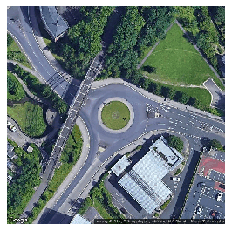

In [15]:
file='data/test/Roundabout/R2.png'
img = tf.keras.preprocessing.image.load_img(file, target_size=[250, 250])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.efficientnet.preprocess_input(
    x[tf.newaxis,...])


In [16]:
predictor.predict(x)

The json_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


b'{\n    "predictions": [[0.0110101579, 0.988987863, 1.98785506e-06]\n    ]\n}'

### Using boto3 sagemaker_runtime client

In [17]:
import boto3
client=boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
EndpointName='your-endpoint-name',
ContentType='application/json',
Body=json.dumps({'instances':x.tolist()}))

In [18]:
json.loads(response['Body'].read().decode("utf-8"))

{'predictions': [[0.0110101579, 0.988987863, 1.98785506e-06]]}

### Attach to a training job that has been left to run 

In [10]:
training_job_name = 'your-training-job-name'

In [11]:
tf_estimator = TensorFlow.attach(training_job_name=training_job_name)


2021-04-14 04:48:40 Starting - Preparing the instances for training
2021-04-14 04:48:40 Downloading - Downloading input data
2021-04-14 04:48:40 Training - Training image download completed. Training in progress.
2021-04-14 04:48:40 Uploading - Uploading generated training model
2021-04-14 04:48:40 Completed - Training job completed


### Sagemaker 2 update endpoint steps

import sagemaker

predictor = sagemaker.pytorch.model.PyTorchPredictor(existing_endpoint_name)
predictor.update_endpoint(initial_instance_count=1, instance_type="ml.p3.2xlarge", model_name= new_model_name)

### Ditributed Data Parallel - Code Modification

https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel-modify-sdp-tf2.html

https://docs.aws.amazon.com/sagemaker/latest/dg/model-parallel-use-api.html

```
import tensorflow as tf

**SageMaker data parallel: Import the library TF API **
import smdistributed.dataparallel.tensorflow as sdp

**SageMaker data parallel: Initialize the library**
sdp.init()

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    # SageMaker data parallel: Pin GPUs to a single library process
    tf.config.experimental.set_visible_devices(gpus[sdp.local_rank()], 'GPU')

**Prepare Dataset**
dataset = tf.data.Dataset.from_tensor_slices(...)

**Define Model**
mnist_model = tf.keras.Sequential(...)
loss = tf.losses.SparseCategoricalCrossentropy()

**SageMaker data parallel: Scale Learning Rate**
*LR for 8 node run : 0.000125*
*LR for single node run : 0.001*
opt = tf.optimizers.Adam(0.000125 * sdp.size())

@tf.function
def training_step(images, labels, first_batch):
    with tf.GradientTape() as tape:
        probs = mnist_model(images, training=True)
        loss_value = loss(labels, probs)

    **SageMaker data parallel: Wrap tf.GradientTape with the library's DistributedGradientTape**
    tape = sdp.DistributedGradientTape(tape)

    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    opt.apply_gradients(zip(grads, mnist_model.trainable_variables))

    if first_batch:
       **SageMaker data parallel: Broadcast model and optimizer variables**
       sdp.broadcast_variables(mnist_model.variables, root_rank=0)
       sdp.broadcast_variables(opt.variables(), root_rank=0)

    return loss_value

# SageMaker data parallel: Save checkpoints only from master node.
if sdp.rank() == 0:
    checkpoint.save(checkpoint_dir)
```

#### On estimator side
```
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    base_job_name = "training_job_name_prefix",
    entry_point="tf-train.py",
    role="SageMakerRole",
    framework_version="2.4.1",
    # You must set py_version to py36
    py_version="py37",
    # For training with multi node distributed training, set this count.
    # Example: 2,3,4,..8
    instance_count=2,
    # For training with p3dn instance use - ml.p3dn.24xlarge
    instance_type="ml.p3.16xlarge",
    # Training using smdistributed.dataparallel Distributed Training Framework
    distribution={"smdistributed": {"dataparallel": {"enabled": True}}}
)

tf_estimator.fit("s3://bucket/path/to/training/data")
```